# Session 3 — Sentence-Level Analysis
## Measure 3: Sentence Embeddings (LLMs as Semantic Encoders)
### BONUS: Comparative Analysis of Alice's Adventures in Wonderland and Through the Looking-Glass

> **Note:** This is an **advanced extension** of notebook `3_1_AppliedNLP_Session3_Sentence_Embeddings.ipynb`. 
> Complete the basic notebook first to understand the fundamentals of sentence embeddings before working through this more complex literary analysis.

---

### What This Bonus Notebook Covers
This advanced demonstration applies sentence embeddings to **real literary texts**, analyzing Lewis Carroll's two Alice books:
- Extracts and compares key sentences from both novels
- Performs multi-dimensional visualization (2D, 3D)
- Automatically discovers thematic clusters
- Quantifies cross-book semantic similarities
- Provides comparative literary analysis

### Prerequisites
Before starting this notebook, you should:
- Complete notebook `3_1` and understand basic sentence embeddings
- Be familiar with PCA (Principal Component Analysis)
- Understand cosine similarity metrics
- Have the Alice books in the `../data/` folder

---

### Quick Review: What are Sentence Embeddings?
Sentence embeddings are **dense vector representations** of sentences that capture their semantic meaning in a high-dimensional space. Unlike traditional word-based approaches, sentence embeddings encode the entire meaning of a sentence into a single fixed-length vector (typically 384-768 dimensions).

### How They Work
Modern sentence embedding models (like SBERT - Sentence-BERT) use **transformer architectures** pre-trained on massive text corpora. These models:
- Convert sentences into numerical vectors where semantically similar sentences are close together in vector space
- Capture context, syntax, and semantic relationships
- Enable comparison of sentences based on meaning rather than just word overlap

### Key Applications in NLP
1. **Semantic Similarity**: Measure how similar two sentences are in meaning
2. **Information Retrieval**: Find relevant documents or passages based on semantic search
3. **Text Clustering**: Group similar sentences or documents together
4. **Duplicate Detection**: Identify paraphrases or semantically identical content
5. **Question Answering**: Match questions with relevant answers
6. **Content Recommendation**: Suggest similar content based on semantic understanding
7. **Comparative Literary Analysis**: Compare themes, writing styles, and narrative patterns across texts

### This Advanced Demonstration
We'll use the **all-MiniLM-L6-v2** model to:
- Extract key sentences from both Alice books using extractive summarization
- Encode sentences into semantic vectors
- Visualize thematic relationships between the two books in 2D/3D space
- Identify semantic similarities and differences between the narratives
- Cluster sentences by themes (e.g., size changes, absurdity, dialogue, fantasy)
- Perform quantitative comparative literature analysis

In [1]:
# Import necessary libraries
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import re
import nltk
from collections import Counter

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Libraries loaded successfully!")

c:\Users\moham\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


Libraries loaded successfully!


In [3]:
# Load the two Alice books
def load_book(filepath):
    """Load and clean book text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Remove Project Gutenberg headers/footers
    start_markers = ['*** START OF', 'CHAPTER I']
    end_markers = ['*** END OF', 'End of Project Gutenberg']
    
    # Find start
    for marker in start_markers:
        if marker in text:
            start = text.find(marker)
            if marker == 'CHAPTER I':
                text = text[start:]
            else:
                text = text[start + len(marker):]
            break
    
    # Find end
    for marker in end_markers:
        if marker in text:
            end = text.find(marker)
            text = text[:end]
            break
    
    return text

# Load both books
crime_text = load_book('../data/Crime-punishment.txt')
brothers_karamazov_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"Crime and Punishment: {len(crime_text):,} characters")
print(f"The Brothers Karamazov: {len(brothers_karamazov_text):,} characters")

Crime and Punishment: 1,224,432 characters
The Brothers Karamazov: 1,956,246 characters


In [4]:
# Extract meaningful sentences from both books
def extract_key_sentences(text, n_sentences=30):
    """
    Extract key sentences using a simple extractive approach:
    - Filter by length (not too short, not too long)
    - Prefer sentences with dialogue or interesting content
    - Avoid repetitive patterns
    """
    # Split into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Clean and filter sentences
    filtered = []
    for sent in sentences:
        # Remove extra whitespace
        sent = ' '.join(sent.split())
        
        # Filter criteria
        word_count = len(sent.split())
        if word_count < 8 or word_count > 40:  # Not too short or long
            continue
        if sent.startswith('CHAPTER'):  # Skip chapter headers
            continue
        if re.match(r'^[IVX]+\.', sent):  # Skip Roman numerals
            continue
        
        filtered.append(sent)
    
    # Score sentences based on interesting features
    scores = []
    for sent in filtered:
        score = 0
        
        # Dialogue is interesting
        if '"' in sent or '"' in sent or '"' in sent:
            score += 2
        
        # Questions are interesting
        if '?' in sent:
            score += 1
        
        # Exclamations add emotion
        if '!' in sent:
            score += 1
        
        # Prefer sentences with Alice
        if 'Alice' in sent:
            score += 1
        
        # Length sweet spot
        word_count = len(sent.split())
        if 12 <= word_count <= 25:
            score += 1
        
        scores.append(score)
    
    # Get top N sentences by score
    scored_sentences = list(zip(filtered, scores))
    scored_sentences.sort(key=lambda x: x[1], reverse=True)
    
    # Return top sentences (without duplicates)
    top_sentences = []
    for sent, score in scored_sentences[:n_sentences * 2]:
        if sent not in top_sentences:
            top_sentences.append(sent)
        if len(top_sentences) >= n_sentences:
            break
    
    return top_sentences

# Extract key sentences from both books
n_per_book = 25
crime_sentences = extract_key_sentences(crime_text, n_per_book)
brothers_karamazov_sentences = extract_key_sentences(brothers_karamazov_text, n_per_book)

print(f"Extracted {len(crime_sentences)} key sentences from Crime and Punishment")
print(f"Extracted {len(brothers_karamazov_sentences)} key sentences from The Brothers Karamazov")
print(f"\nTotal sentences to analyze: {len(crime_sentences) + len(brothers_karamazov_sentences)}")
# Show a few examples
print("\n" + "="*80)
print("SAMPLE FROM CRIME AND PUNISHMENT:")
print("="*80)
for i, sent in enumerate(crime_sentences[:3], 1):
    print(f"{i}. {sent}")

print("\n" + "="*80)
print("SAMPLE FROM THE BROTHERS KARAMAZOV:")
print("="*80)
for i, sent in enumerate(brothers_karamazov_sentences[:3], 1):
    print(f"{i}. {sent}")

Extracted 25 key sentences from Crime and Punishment
Extracted 25 key sentences from The Brothers Karamazov

Total sentences to analyze: 50

SAMPLE FROM CRIME AND PUNISHMENT:
1. He-he-he!” “You don’t say she gave it to you?” cried one of the new-comers; he shouted the words and went off into a guffaw.
2. And you, are you not ashamed?” — she pounced all at once upon Raskolnikov — “from the tavern!
3. I’ll do for her!” 92 crime and punishment “What are you about, are you a Christian, you devil?” shouted an old man in the crowd.

SAMPLE FROM THE BROTHERS KARAMAZOV:
1. After Alexey, the man of God?” “Yes, Father.” “What a saint he was!
2. Is that your little girl?” “My little girl, Father, Lizaveta.” “May the Lord bless you both, you and your babe Lizaveta!
3. And who could help loving them, our splendid Russian people, so simple in their greatness!” “How is your daughter’s health?


In [5]:
# Load sentence transformer model and generate embeddings
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine sentences and track their sources
all_sentences = crime_sentences + brothers_karamazov_sentences
book_labels = ['Crime and Punishment'] * len(crime_sentences) + ['The Brothers Karamazov'] * len(brothers_karamazov_sentences)

# Generate embeddings
print("Generating embeddings...")
embeddings = model.encode(all_sentences, show_progress_bar=True)

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Each sentence → {embeddings.shape[1]}-dimensional vector")

Loading sentence transformer model...
Generating embeddings...


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Embedding shape: (50, 384)
Each sentence → 384-dimensional vector


In [6]:
# Perform clustering to identify themes
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

print(f"Identified {n_clusters} thematic clusters")
print("\nCluster distribution:")
for i in range(n_clusters):
    count = sum(clusters == i)
    crime_count = sum((clusters == i) & (np.array(book_labels) == 'Crime and Punishment'))
    brothers_karamazov_count = sum((clusters == i) & (np.array(book_labels) == 'The Brothers Karamazov'))
    print(f"  Cluster {i}: {count} sentences (CP:{crime_count}, BK:{brothers_karamazov_count})")

Identified 5 thematic clusters

Cluster distribution:
  Cluster 0: 2 sentences (CP:1, BK:1)
  Cluster 1: 6 sentences (CP:1, BK:5)
  Cluster 2: 11 sentences (CP:8, BK:3)
  Cluster 3: 18 sentences (CP:10, BK:8)
  Cluster 4: 13 sentences (CP:5, BK:8)


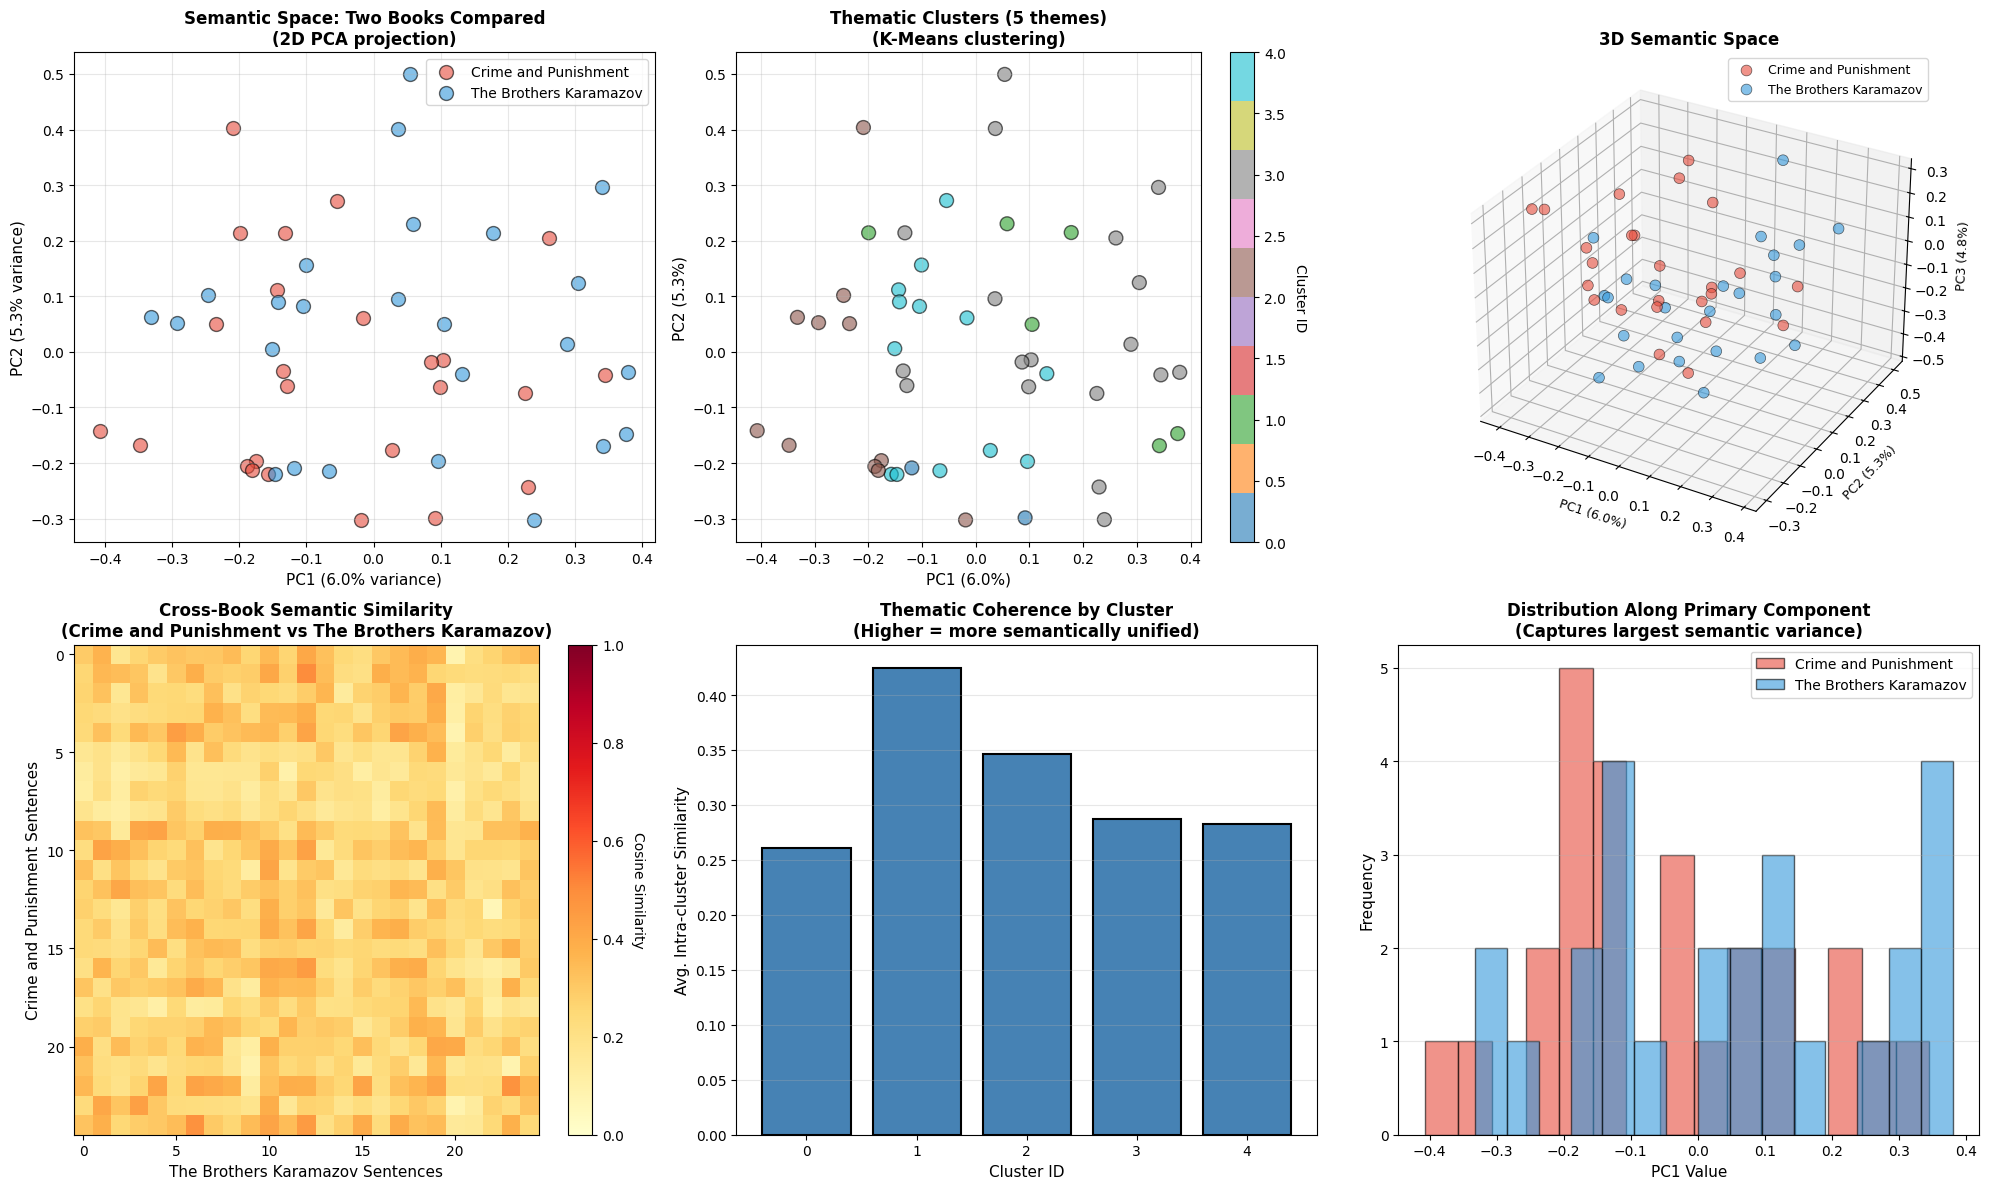

In [ ]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# Define colors for the two books
colors_dict = {'Crime and Punishment': '#e74c3c', 'The Brothers Karamazov': '#3498db'}
colors = [colors_dict[label] for label in book_labels]

# --- Plot 1: 2D PCA with book distinction ---
ax1 = plt.subplot(2, 3, 1)
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embeddings)

for book in ['Crime and Punishment', 'The Brothers Karamazov']:
    mask = np.array(book_labels) == book
    ax1.scatter(points_2d[mask, 0], points_2d[mask, 1], 
               c=colors_dict[book], label=book, alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Semantic Space: Two Books Compared\n(2D PCA projection)', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 2: 2D PCA with clusters ---
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(points_2d[:, 0], points_2d[:, 1], c=clusters, 
                     cmap='tab10', alpha=0.6, s=100, edgecolors='black', linewidth=1)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax2.set_title(f'Thematic Clusters ({n_clusters} themes)\n(K-Means clustering)', 
             fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# --- Plot 3: 3D PCA ---
ax3 = plt.subplot(2, 3, 3, projection='3d')
pca_3d = PCA(n_components=3)
points_3d = pca_3d.fit_transform(embeddings)

for book in ['Crime and Punishment', 'The Brothers Karamazov']:
    mask = np.array(book_labels) == book
    ax3.scatter(points_3d[mask, 0], points_3d[mask, 1], points_3d[mask, 2],
               c=colors_dict[book], label=book, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

ax3.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=9)
ax3.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=9)
ax3.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=9)
ax3.set_title('3D Semantic Space', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)

# --- Plot 4: Cross-book similarity matrix ---
ax4 = plt.subplot(2, 3, 4)

# Compute similarity between Crime and Punishment and The Brothers Karamazov
crime_embeddings = embeddings[:len(crime_sentences)]
brothers_karamazov_embeddings = embeddings[len(crime_sentences):]
cross_similarity = util.cos_sim(crime_embeddings, brothers_karamazov_embeddings).numpy()

im = ax4.imshow(cross_similarity, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15, fontsize=10)
ax4.set_xlabel('The Brothers Karamazov Sentences', fontsize=11)
ax4.set_ylabel('Crime and Punishment Sentences', fontsize=11)
ax4.set_title('Cross-Book Semantic Similarity\n(Crime and Punishment vs The Brothers Karamazov)', 
             fontsize=12, fontweight='bold')

# --- Plot 5: Average similarity per cluster ---
ax5 = plt.subplot(2, 3, 5)

cluster_similarities = []
for i in range(n_clusters):
    cluster_mask = clusters == i
    if sum(cluster_mask) > 1:
        cluster_emb = embeddings[cluster_mask]
        sim_matrix = util.cos_sim(cluster_emb, cluster_emb).numpy()
        # Average similarity (excluding diagonal)
        avg_sim = (sim_matrix.sum() - sim_matrix.trace()) / (sim_matrix.size - len(cluster_emb))
        cluster_similarities.append(avg_sim)
    else:
        cluster_similarities.append(0)

bars = ax5.bar(range(n_clusters), cluster_similarities, color='steelblue', edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Cluster ID', fontsize=11)
ax5.set_ylabel('Avg. Intra-cluster Similarity', fontsize=11)
ax5.set_title('Thematic Coherence by Cluster\n(Higher = more semantically unified)', 
             fontsize=12, fontweight='bold')
ax5.set_xticks(range(n_clusters))
ax5.grid(True, alpha=0.3, axis='y')

# --- Plot 6: Distribution histogram ---
ax6 = plt.subplot(2, 3, 6)

crime_pc1 = points_2d[:len(crime_sentences), 0]
brothers_karamazov_pc1 = points_2d[len(crime_sentences):, 0]

ax6.hist(crime_pc1, bins=15, alpha=0.6, color='#e74c3c', label='Crime and Punishment', edgecolor='black')
ax6.hist(brothers_karamazov_pc1, bins=15, alpha=0.6, color='#3498db', label='The Brothers Karamazov', edgecolor='black')
ax6.set_xlabel('PC1 Value', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Distribution Along Primary Component\n(Captures largest semantic variance)', 
             fontsize=12, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Interpreting the Visualizations CP & TBK

**Top Left - Book Comparison (2D):**
- Red points = Crime and Punishment
- Blue points = The Brothers Karamazov
- Spatial proximity indicates semantic similarity
- Overlapping regions suggest shared themes between books

**Top Middle - Thematic Clusters:**
- Color-coded by automatically detected themes
- K-Means clustering groups semantically similar sentences
- Reveals common narrative patterns across both books

**Top Right - 3D Semantic Space:**
- Three-dimensional view captures more variance
- Rotation would show different perspectives on semantic relationships
- Preserves more information than 2D projection

**Bottom Left - Cross-Book Similarity Matrix:**
- Heat map showing similarity between every Crime and Punishment sentence and every The Brothers Karamazov sentence
- Bright areas indicate highly similar passages
- Reveals which scenes/themes are shared across books

**Bottom Middle - Cluster Coherence:**
- Measures how semantically unified each theme cluster is
- Higher bars = sentences in that cluster are more similar to each other
- Indicates strength of thematic grouping

**Bottom Right - Distribution Analysis:**
- Shows how the books differ along the primary semantic dimension
- Overlapping distributions suggest similar semantic content
- Separated peaks would indicate distinct narrative styles


In [8]:
# Analyze each cluster to understand themes
print("="*80)
print("THEMATIC ANALYSIS OF CLUSTERS")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_sentences = [sent for sent, mask in zip(all_sentences, cluster_mask) if mask]
    cluster_books = [book for book, mask in zip(book_labels, cluster_mask) if mask]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {len(cluster_sentences)} sentences")
    print(f"  Crime and Punishment: {cluster_books.count('Crime and Punishment')}, The Brothers Karamazov: {cluster_books.count('The Brothers Karamazov')}")
    print(f"{'='*80}")
    
    # Show representative sentences (up to 3)
    for i, (sent, book) in enumerate(zip(cluster_sentences[:3], cluster_books[:3]), 1):
        book_abbr = "CP" if book == "Crime and Punishment" else "BK"
        # Truncate if too long
        display_sent = sent if len(sent) < 100 else sent[:97] + "..."
        print(f"{i}. [{book_abbr}] {display_sent}")
    
    if len(cluster_sentences) > 3:
        print(f"   ... and {len(cluster_sentences) - 3} more sentences")

THEMATIC ANALYSIS OF CLUSTERS

CLUSTER 0: 2 sentences
  Crime and Punishment: 1, The Brothers Karamazov: 1
1. [CP] And she dressed up like a regular fashion book!” “And what is a fashion book?” the younger one as...
2. [BK] But that was acting, too﻿—you were playing a part﻿—as in a theater!” “In a theater?

CLUSTER 1: 6 sentences
  Crime and Punishment: 1, The Brothers Karamazov: 5
1. [CP] “He will die immediately.” “Is there really no hope?” “Not the faintest!
2. [BK] Shall I say, Mitya?” “Be silent!” cried Dmitri, “wait till I’m gone.
3. [BK] ‘Be noble, O man!’﻿—who says that?” Alyosha made up his mind to wait.
   ... and 3 more sentences

CLUSTER 2: 11 sentences
  Crime and Punishment: 8, The Brothers Karamazov: 3
1. [CP] I’ll do for her!” 92 crime and punishment “What are you about, are you a Christian, you devil?” s...
2. [CP] “Why wouldn’t she gallop then?” “My property!” shouted Mikolka, with bloodshot eyes, brandishing ...
3. [CP] Listen!” “Well?” “You are talking and speechify

In [9]:
# Find most similar cross-book sentence pairs
print("="*80)
print("MOST SIMILAR SENTENCES ACROSS BOOKS")
print("="*80)
print("Finding thematic parallels between Wonderland and Looking-Glass...\n")

# Get cross-book similarities
crime_embeddings = embeddings[:len(crime_sentences)]
brothers_karamazov_embeddings = embeddings[len(crime_sentences):]
cross_similarity = util.cos_sim(crime_embeddings, brothers_karamazov_embeddings).numpy()

# Find top 5 most similar pairs
pairs = []
for i in range(len(crime_sentences)):
    for j in range(len(brothers_karamazov_sentences)):
        pairs.append((i, j, cross_similarity[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

for rank, (i, j, score) in enumerate(pairs[:5], 1):
    print(f"{rank}. Similarity: {score:.4f}")
    print(f"   [Crime and Punishment] {crime_sentences[i][:120]}...")
    print(f"   [The Brothers Karamazov] {brothers_karamazov_sentences[j][:120]}...")
    print()

MOST SIMILAR SENTENCES ACROSS BOOKS
Finding thematic parallels between Wonderland and Looking-Glass...

1. Similarity: 0.4991
   [Crime and Punishment] And you, are you not ashamed?” — she pounced all at once upon Raskolnikov — “from the tavern!...
   [The Brothers Karamazov] And, how could I tell her myself?” “And where are you going?” “To the back-alley.” “To Grushenka, then!” Alyosha exclaim...

2. Similarity: 0.4835
   [Crime and Punishment] So give me your hand, good-bye!” “What’s the matter with you, Rodya?” “Nothing ....
   [The Brothers Karamazov] Shall I say, Mitya?” “Be silent!” cried Dmitri, “wait till I’m gone....

3. Similarity: 0.4796
   [Crime and Punishment] “He will die immediately.” “Is there really no hope?” “Not the faintest!...
   [The Brothers Karamazov] And he thinks that will be a satisfactory finish, doesn’t he?” “Oh, no!...

4. Similarity: 0.4521
   [Crime and Punishment] So give me your hand, good-bye!” “What’s the matter with you, Rodya?” “Nothing ....
   [T

### Key Insights from This Analysis

**What We Discovered:**
1. **Semantic Embeddings** transform text into numbers while preserving meaning
2. **Dimensionality Reduction** (PCA) reveals hidden patterns in high-dimensional data
3. **Clustering** automatically discovers thematic groups without manual labeling
4. **Cross-book Analysis** quantifies narrative similarities between related texts

**Literary Applications:**
- **Authorship Analysis**: Detect writing style consistency across works
- **Theme Tracking**: Identify recurring motifs and narrative patterns
- **Comparative Literature**: Quantify similarities between different texts
- **Character Development**: Track how character representations evolve
- **Influence Detection**: Measure semantic similarity between works from different authors

**Limitations to Consider:**
- PCA dimensionality reduction loses information (check variance percentages)
- Sentence extraction is simplified - more sophisticated methods exist
- Context beyond sentence boundaries is not captured
- Model was trained on modern text, may not fully capture Victorian nuances
- Clustering number (k=5) was arbitrary - could be optimized

**Extensions You Could Try:**
- Analyze chapter-by-chapter semantic evolution
- Compare Alice books to other Victorian literature
- Track character-specific language patterns
- Identify dialogue vs. narrative differences
- Build a semantic search engine for the texts